In [1]:
import sys
sys.path.append("..")
import importlib
import numpy as np
import matplotlib.pyplot as plt
import qutip
import scipy as sp
from tqdm import tqdm as tqdm
from qutip.parallel import parallel_map as parallel_map
from qutip.parallel import parfor as parfor

import system.from_higher_basis_truncation_tunable_full_cosine as system
importlib.reload(system)
import utils.floquet_solver as fsolver
importlib.reload(fsolver)
import utils.solver as solver
importlib.reload(solver)
import pulse.tanh as tanh
importlib.reload(tanh)
import utils.expectation_values as expv
importlib.reload(expv)
import utils.floquetify as floqify
importlib.reload(floqify)
import utils.graph as graph
importlib.reload(graph)
pass

# Generate a Landscape

In [18]:
def inner(dur):
    global t_multiplier, amplitude, freq, ramp_slope
    tlist = np.linspace(0, dur, int(dur*t_multiplier + t_multiplier))
    tanh.setup(amplitude=amplitude, drive_frequency=freq, ramp_slope=ramp_slope, cut_factor=cut_factor, tlist=tlist)
    ramp_time = 16 # roughly 13, but this makes it even closer to correct
    s = fsolver.time_evolve(system.H0, system.H1, tanh, ramp_time, ramp_time, ((2*np.pi)/freq), tlist, system.starting_state)
    # s = solver.time_evolve(system.H0, system.H1, tanh.pulse_func, tlist, system.starting_state)
    fidelity = expv.expectation_value(s.states[-1], system.target_state)
    return fidelity

def generate_fidelity_landscape(_amplitude, freq_list, dur_list, _t_multiplier=5, skip_rate=1):
    global t_multiplier, amplitude, freq, ramp_slope
    t_multiplier = _t_multiplier
    amplitude = _amplitude
    fids = [] # an array of columns in the landscape
    freq_points = np.linspace(np.amin(freq_list), np.amax(freq_list), int(len(freq_list)/skip_rate))
    dur_points = np.linspace(np.amin(dur_list), np.amax(dur_list), int(len(dur_list)/skip_rate))
    for f in tqdm(freq_points):
        freq = f
        # in parallel
        fids.append(parallel_map(inner, dur_points))

        # sync
        # temp_fids = []
        # for dur in dur_points:
        #     temp_fids.append(inner(dur))
        # fids.append(temp_fids)

    fids = np.swapaxes(fids,0,1)

    plt.pcolormesh(freq_points, dur_points, fids, shading='auto')
    plt.colorbar()
    plt.xlabel("frequency (GHz)")
    plt.ylabel("duration (ns)")
    
    return fids

In [3]:
import dill
def load_via_dill(name):
    name = "../save_data/" + name + ".dill"
    with open(name, "rb") as f:
        return dill.load(f)
first_results = load_via_dill("Dec5_7-3.5_tanh_params_as_function_of_amplitude")
second_results = load_via_dill("Dec5_7-15_tanh_params_as_function_of_amplitude")
third_results = load_via_dill("Dec5_15-30_tanh_params_as_function_of_amplitude")
super_results = list(np.flip(first_results)) + second_results + third_results

In [6]:
i = 70
super_results[i]

{'amplitude': 10.419172484400761,
 'offset': 0.2313735325060422,
 'duration': 43.45999680388603,
 'fidelity': 0.99892192360175,
 'end_early': False,
 'iterations': 48}

  0%|          | 0/65 [00:00<?, ?it/s]

{'amplitude': 10.419172484400761, 'offset': 0.2313735325060422, 'duration': 43.45999680388603, 'fidelity': 0.99892192360175, 'end_early': False, 'iterations': 48}


100%|██████████| 65/65 [22:58<00:00, 21.21s/it]


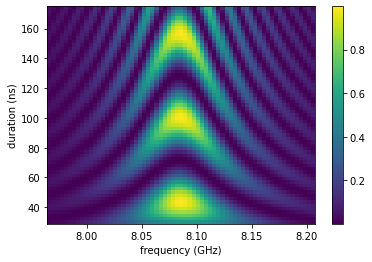

In [26]:
i = 70
print(super_results[i])
amplitude = super_results[i]["amplitude"]
duration = super_results[i]["duration"]
landscape_offset = super_results[i]["offset"]
landscape_central_freq = system.first_energy_spacing/3 - landscape_offset
evaluation_points = 65

landscape_freq_list = np.linspace(landscape_central_freq - 0.12, landscape_central_freq + 0.12, evaluation_points)
landscape_dur_list = np.linspace(30, duration*4, evaluation_points)

t_multiplier = 2
ramp_slope = 0.5
cut_factor = 3

landscape_fid_list = generate_fidelity_landscape(amplitude, landscape_freq_list, landscape_dur_list, t_multiplier)

# Define points for floquet analysis

In [37]:
points = [(8.05,100), (8.06,100), (8.07,100),  (8.08,100), (8.09,100), (8.10,100), (8.11,100),
(8.06,45), (8.07,45),  (8.08,45), (8.09,45), (8.10,45), (8.11,45),
(8.04,100), (8.035,100), (8.03,100)] # [ (frequency, duration) ]
freq_points = [freq for freq, dur in points]
dur_points = [dur for freq, dur in points]

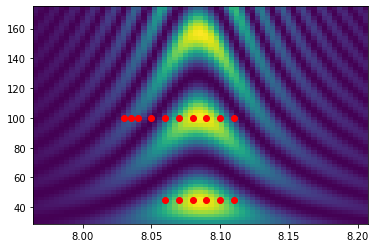

In [38]:
plt.pcolormesh(landscape_freq_list, landscape_dur_list, landscape_fid_list, shading="auto")
plt.scatter(freq_points,dur_points, c="red")

# Look at first point

In [29]:
def look_at_point(point_index):
    point_freq = freq_points[point_index]
    point_dur = dur_points[point_index]

    print(" ~ Looking at point %i (%f , %f) ~ " % (point_index, point_dur, point_freq))

    # graph showing where this dot is
    plt.pcolormesh(landscape_freq_list, landscape_dur_list, landscape_fid_list, shading="auto")
    plt.scatter(point_freq, point_dur, c="red")
    plt.xlabel("frequency (angular GHz)")
    plt.ylabel("duration (ns)")
    plt.show()

    # pulse setup and graph
    tlist = np.sort(list(np.arange(0, point_dur, (2*np.pi)/(point_freq*200))) + [point_dur])
    tanh.setup(amplitude, point_freq, ramp_slope, cut_factor, tlist)
    # plt.plot(tlist, tanh.get_pulse(tlist))
    # plt.xlabel("duration (ns)")
    # plt.ylabel("pulse amplitude")
    # plt.show()

    solution = solver.time_evolve(system.H0, system.H1, tanh.pulse_func, tlist, system.starting_state)
    graph.graph_solution(solution, system)
    plt.plot()

    importlib.reload(floqify)
    floquet_results = floqify.floquetify(system, solution, tanh, tlist)

    plt.figure(figsize=(10,10))
    for i in range(0, len(floquet_results["expectation_values"])):
        o = floquet_results["expectation_values"][i]
        plt.plot(floquet_results["dur_points"], o, label=r'floquet mode %i' % i)
    plt.legend()
    plt.xlabel("time (ns)")
    plt.ylabel(r'overlap of $\psi_t$ with floquet mode')
    plt.ylim((-0.1, 1.1))
    plt.show()

    plt.figure(figsize=(10,10))
    for i in range(10):
        plt.scatter(floquet_results["dur_points"], np.array(floquet_results["ordered_energies"])[:,i], label=r'quasi energy %i' % i)
    plt.legend()
    plt.xlabel("time (ns)")
    plt.ylabel(r'quasi energy')
    plt.show()

# Run through all points

 ~ Looking at point 0 (100.000000 , 8.050000) ~ 


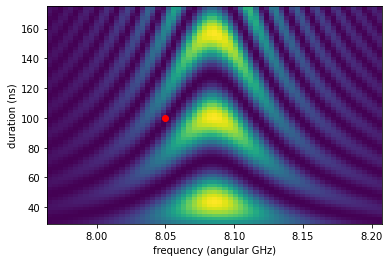

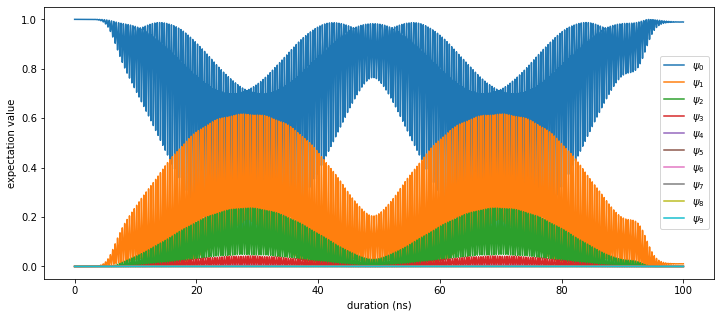

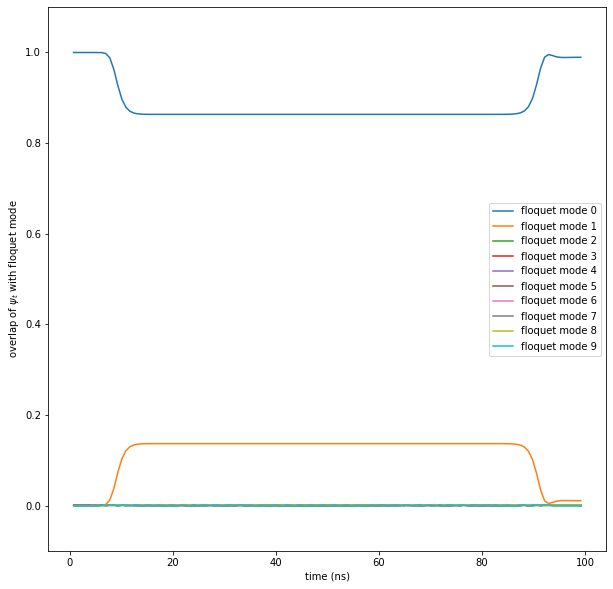

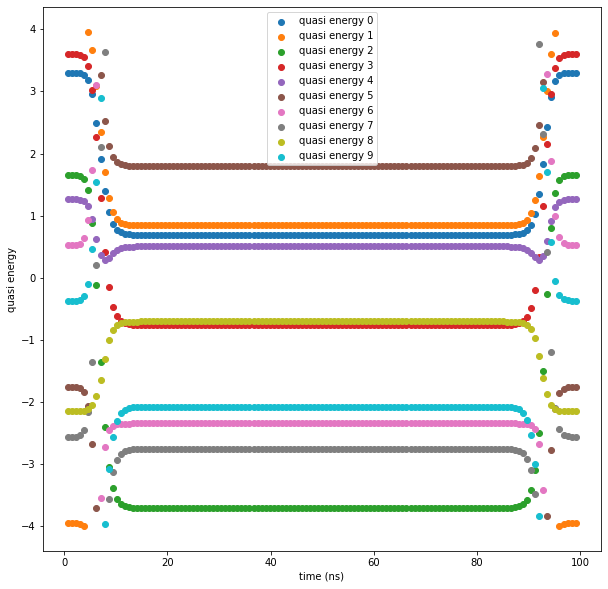

 ~ Looking at point 1 (100.000000 , 8.060000) ~ 


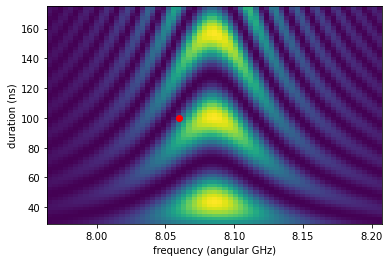

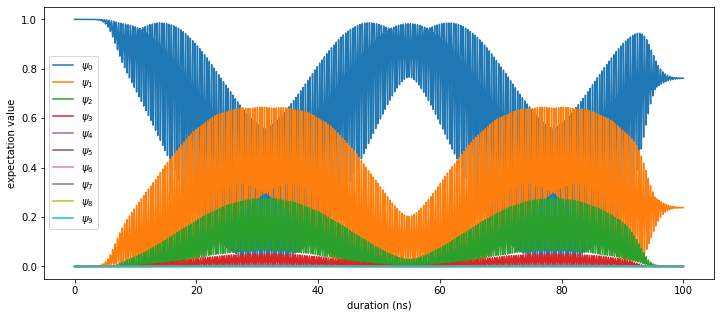

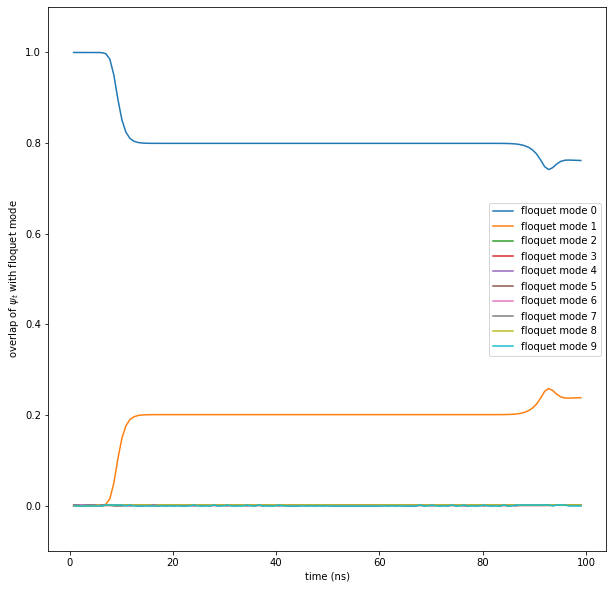

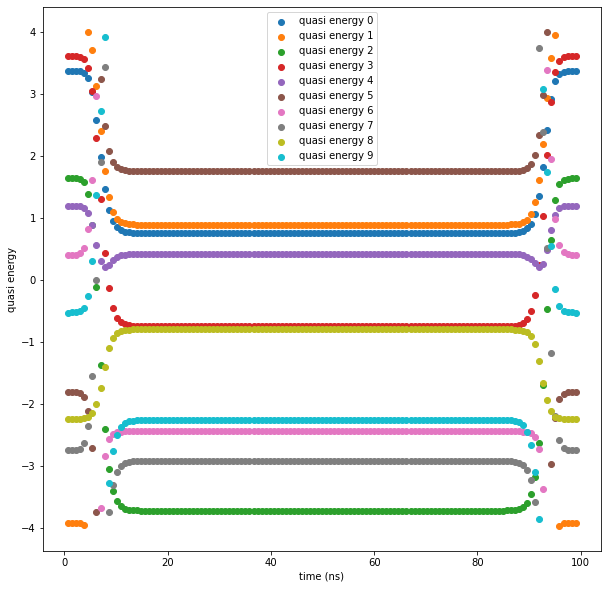

 ~ Looking at point 2 (100.000000 , 8.070000) ~ 


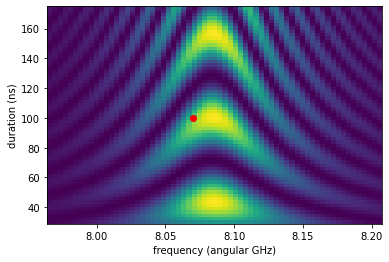

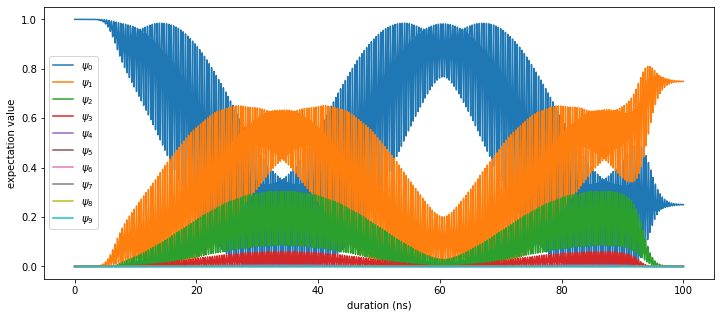

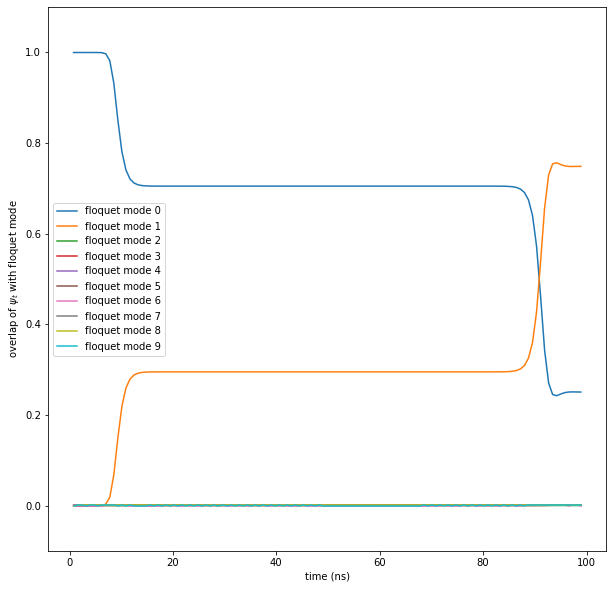

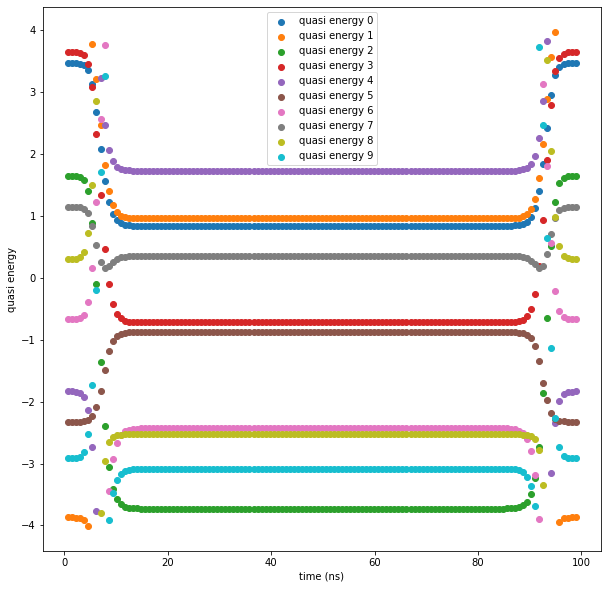

 ~ Looking at point 3 (100.000000 , 8.080000) ~ 


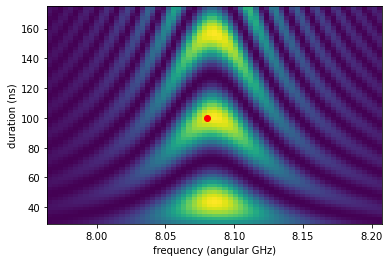

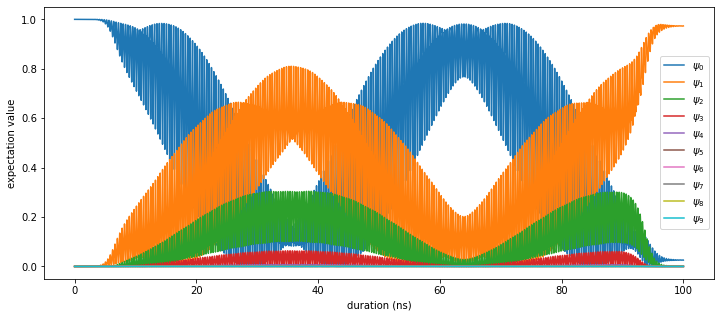

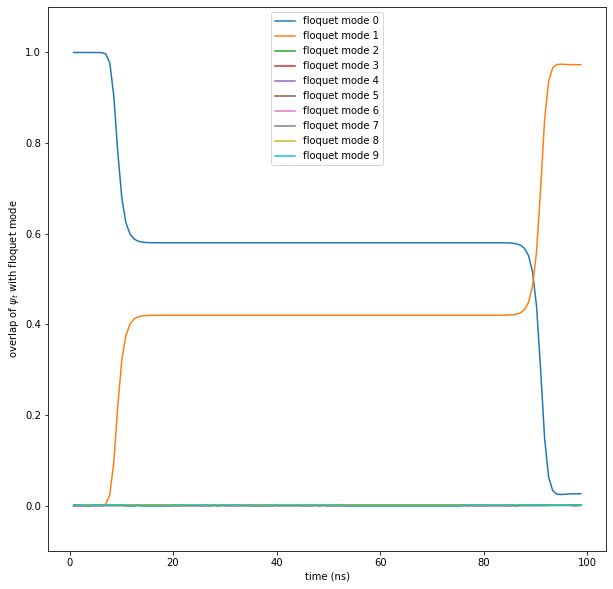

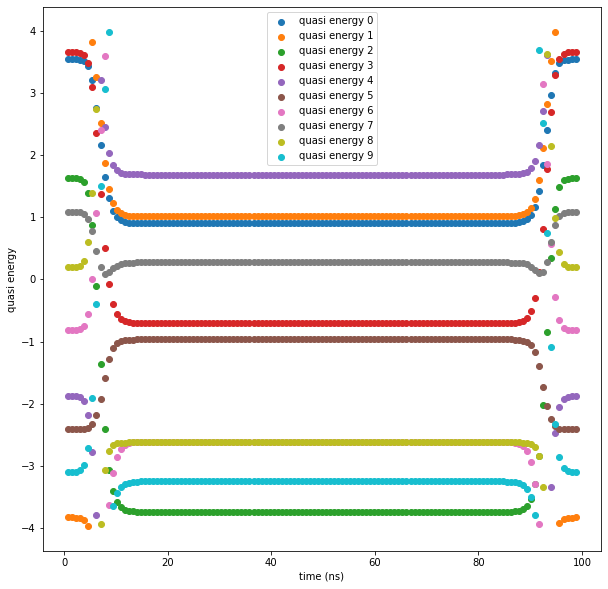

 ~ Looking at point 4 (100.000000 , 8.090000) ~ 


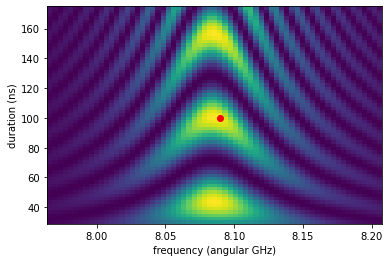

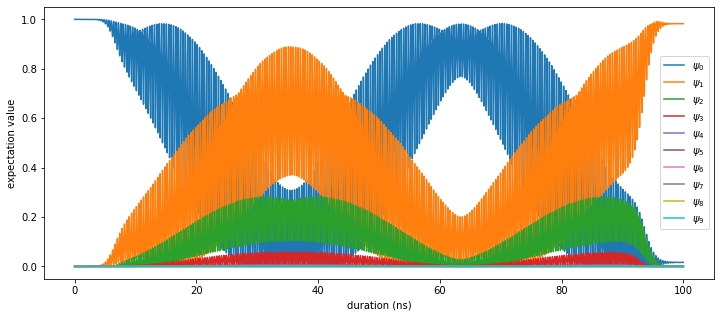

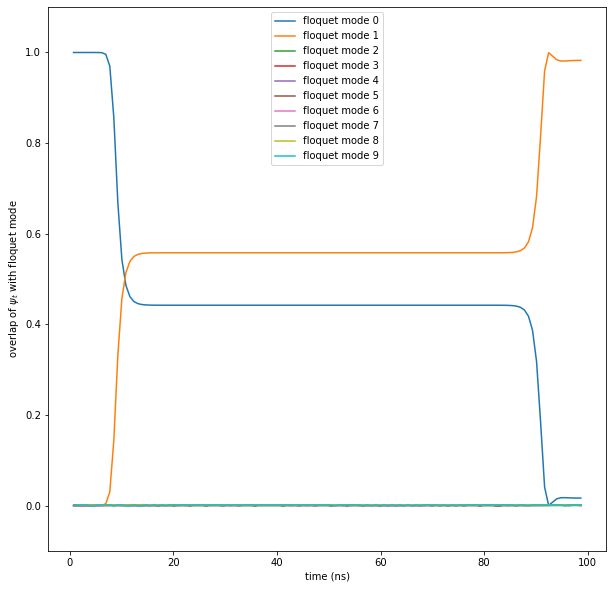

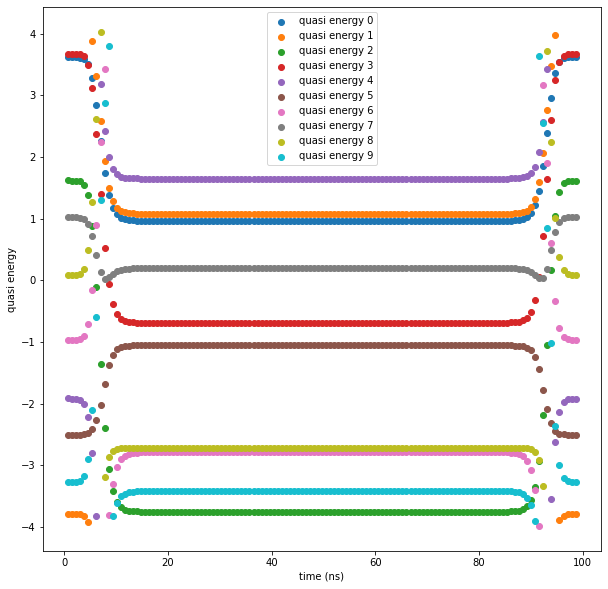

 ~ Looking at point 5 (100.000000 , 8.100000) ~ 


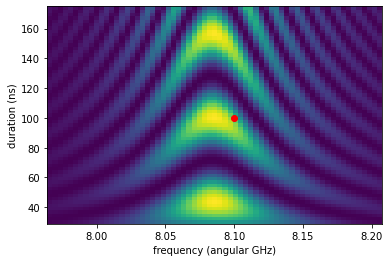

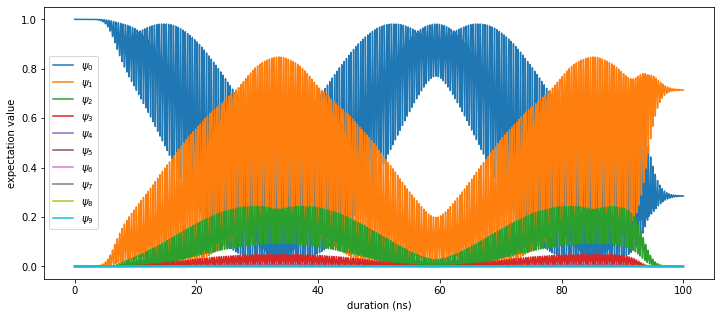

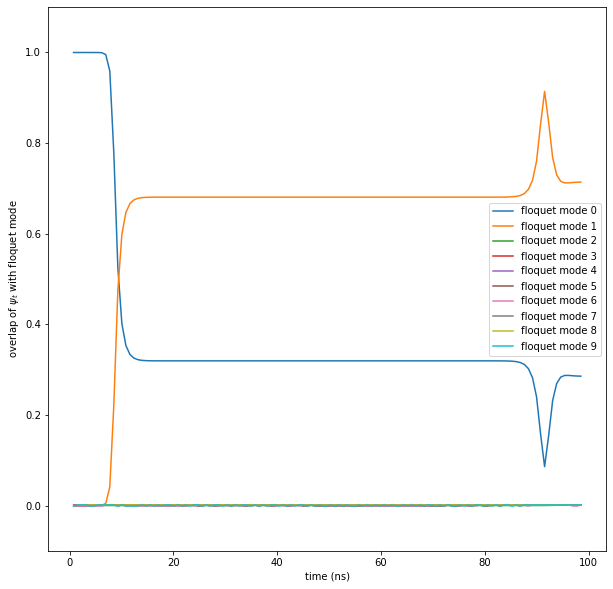

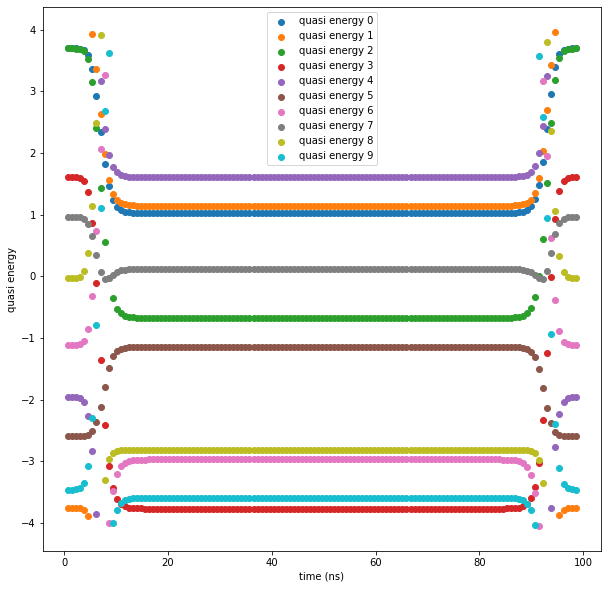

 ~ Looking at point 6 (100.000000 , 8.110000) ~ 


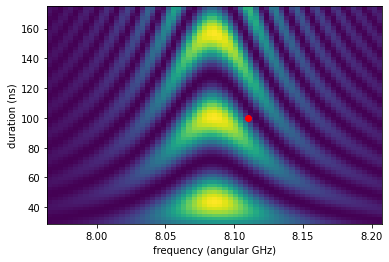

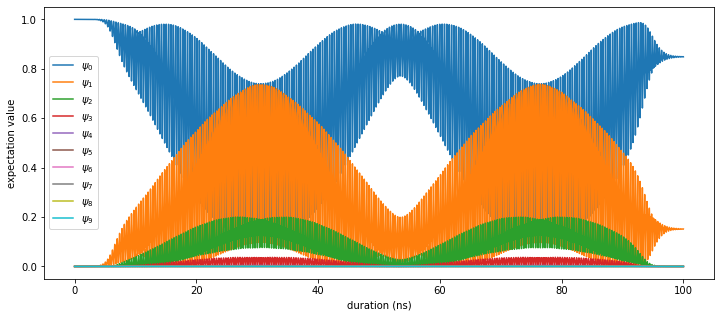

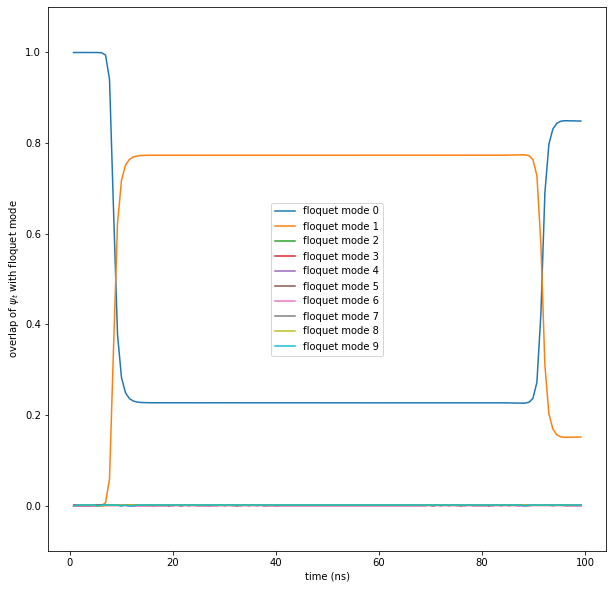

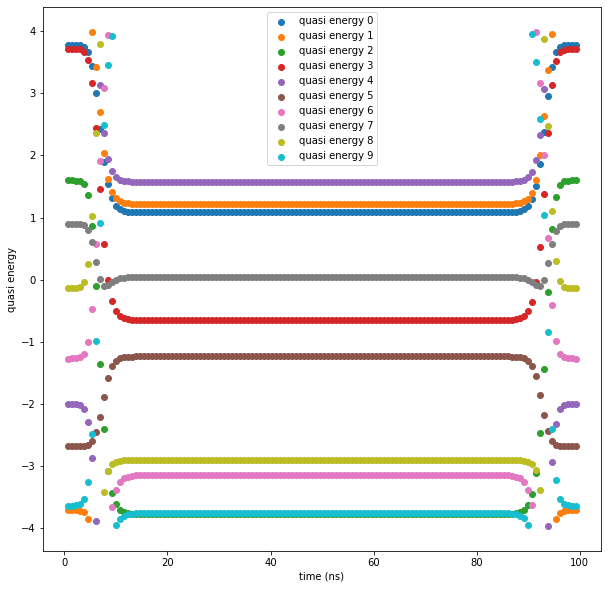

 ~ Looking at point 7 (45.000000 , 8.060000) ~ 


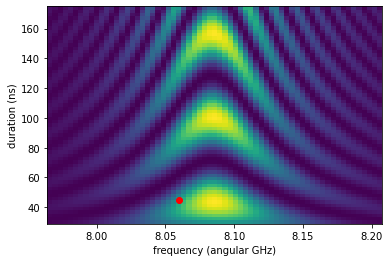

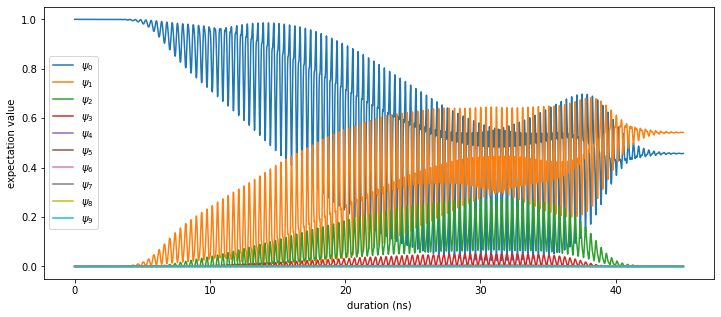

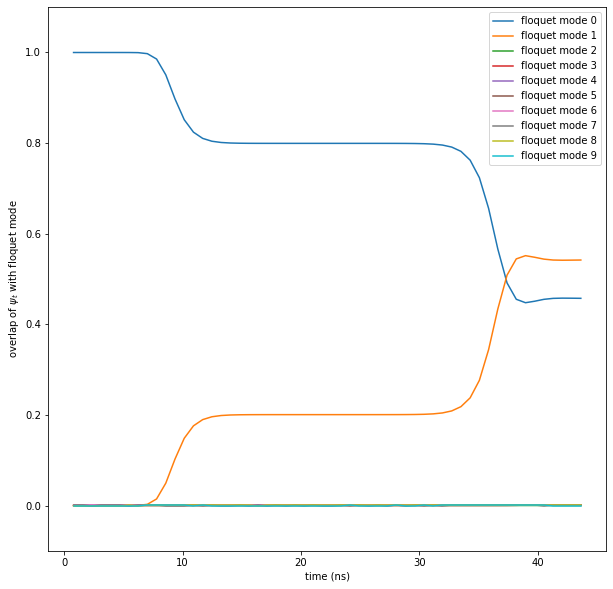

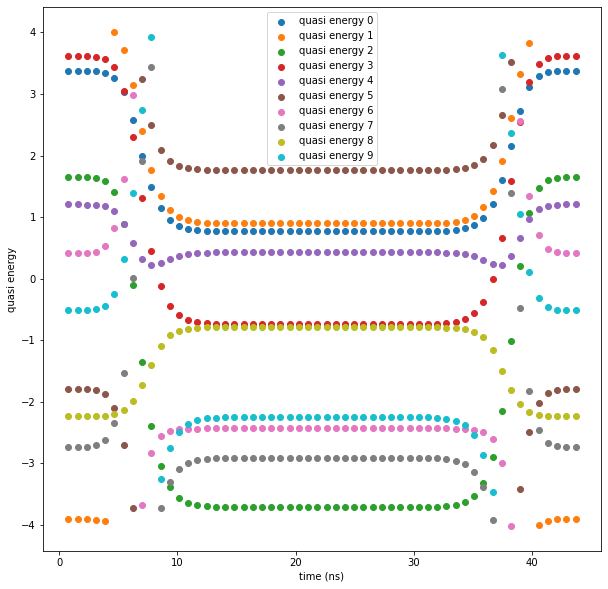

 ~ Looking at point 8 (45.000000 , 8.070000) ~ 


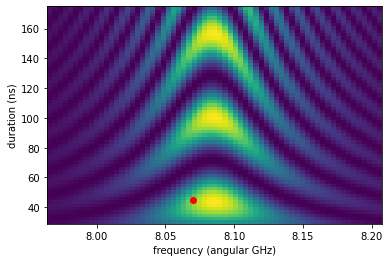

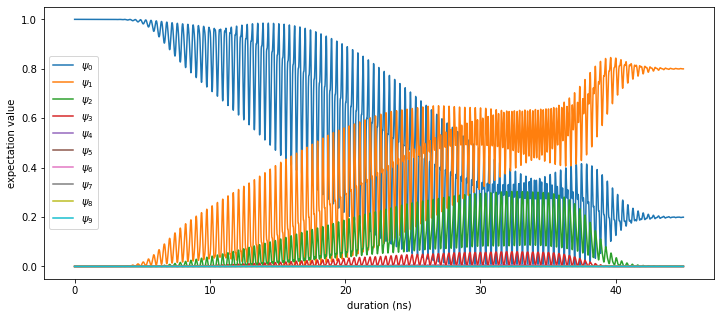

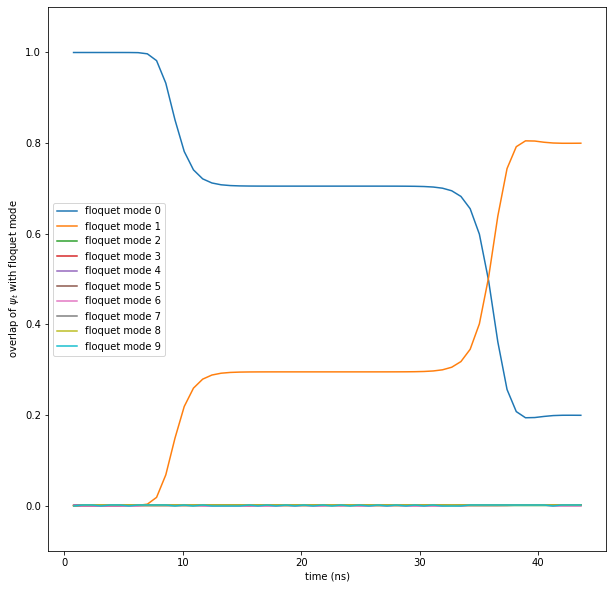

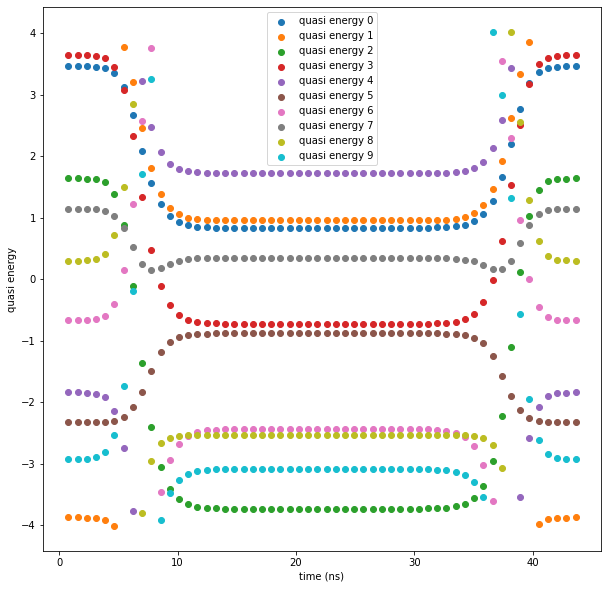

 ~ Looking at point 9 (45.000000 , 8.080000) ~ 


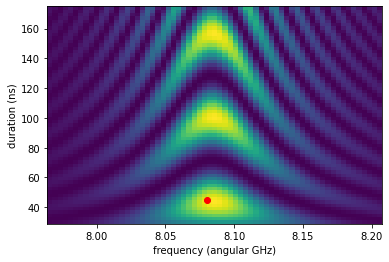

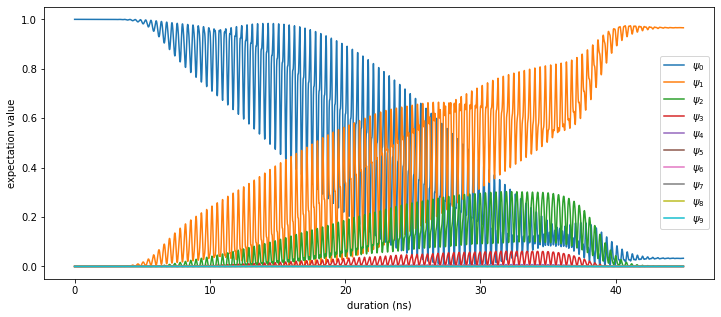

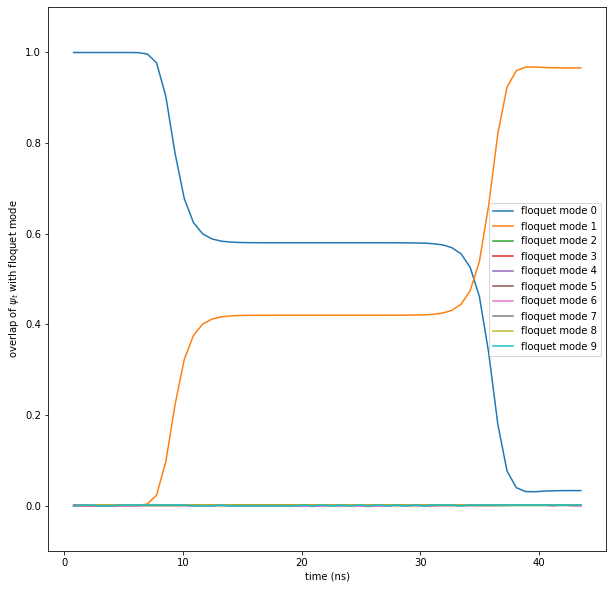

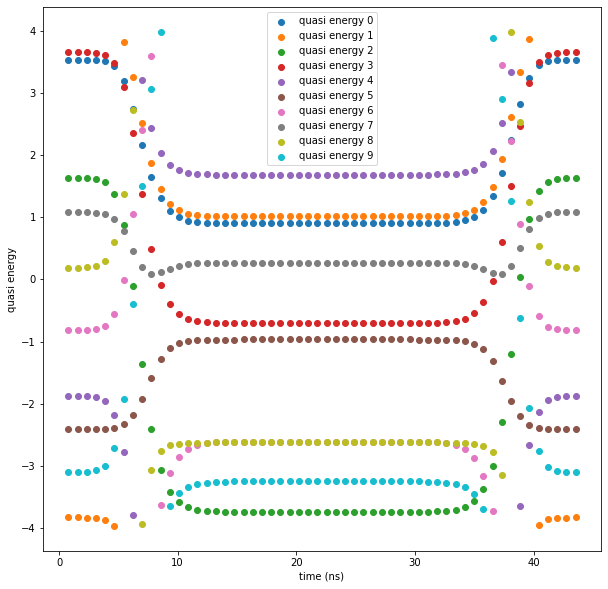

 ~ Looking at point 10 (45.000000 , 8.090000) ~ 


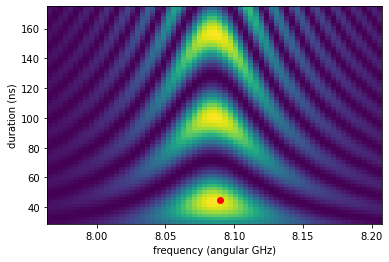

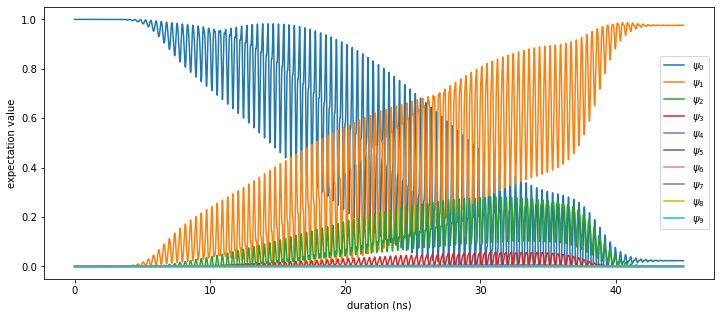

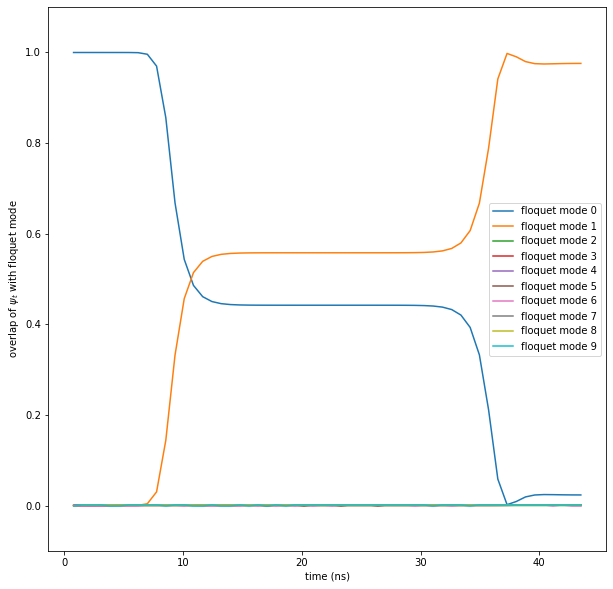

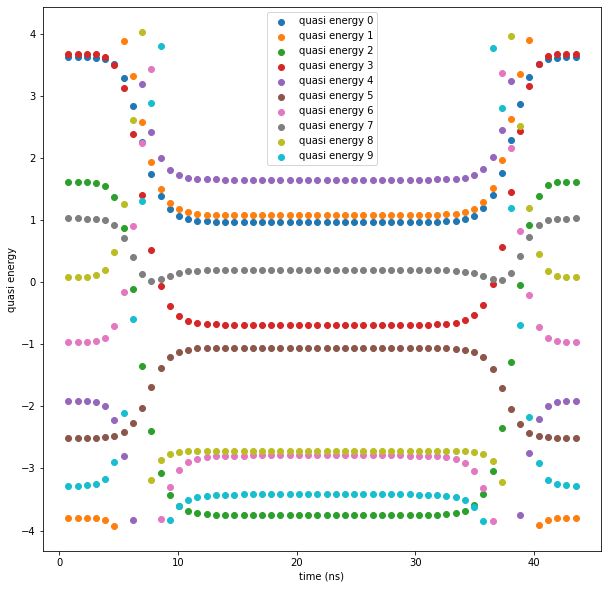

 ~ Looking at point 11 (45.000000 , 8.100000) ~ 


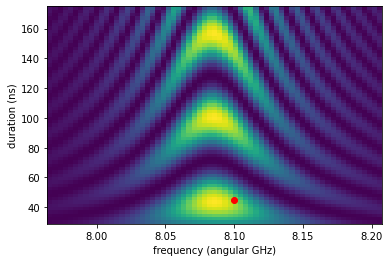

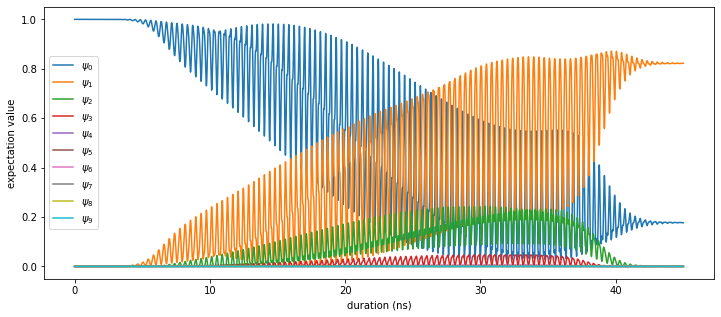

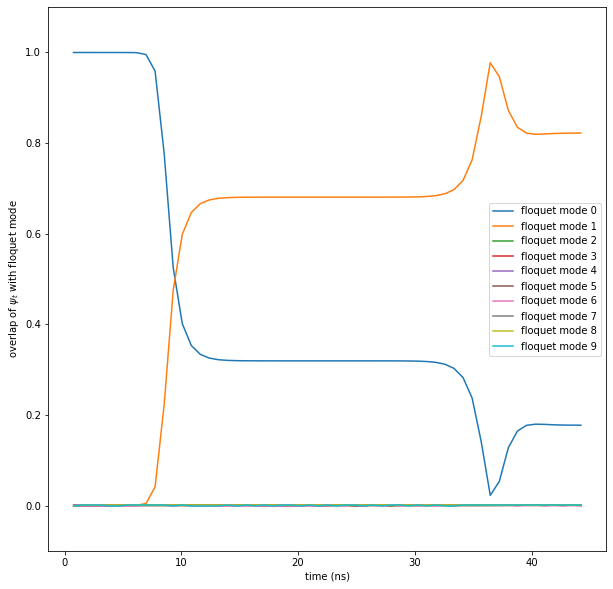

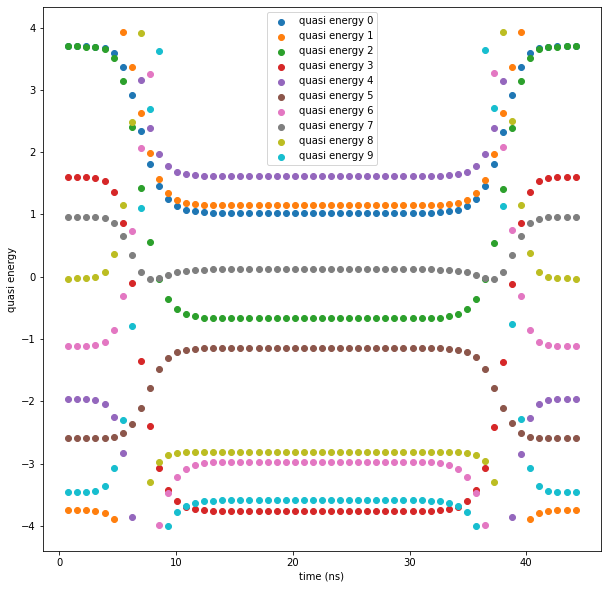

 ~ Looking at point 12 (45.000000 , 8.110000) ~ 


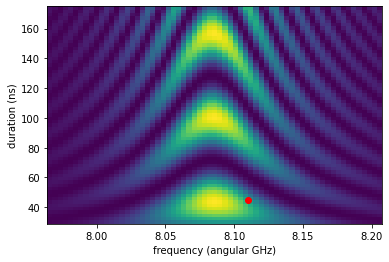

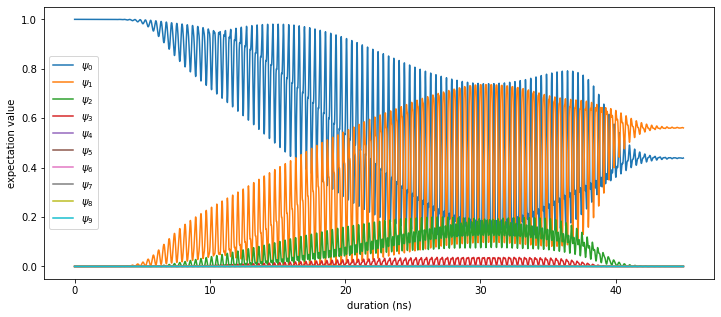

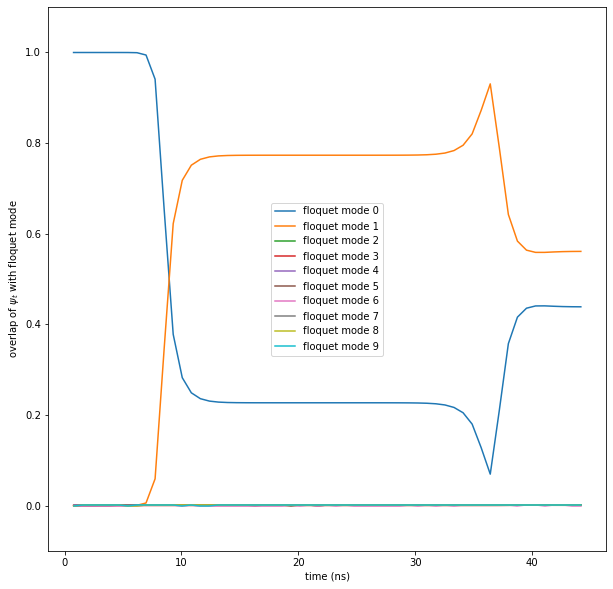

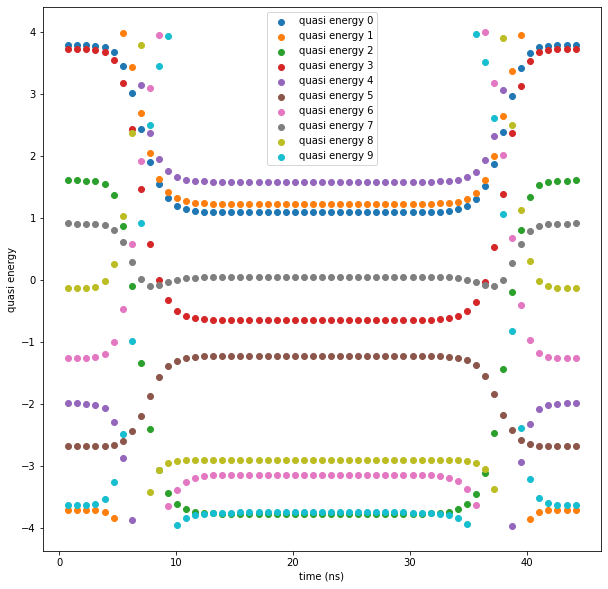

 ~ Looking at point 13 (100.000000 , 8.040000) ~ 


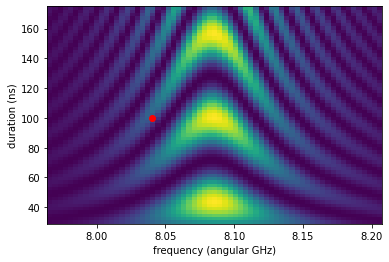

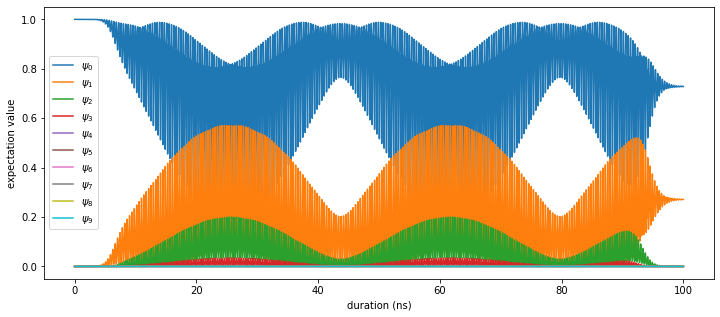

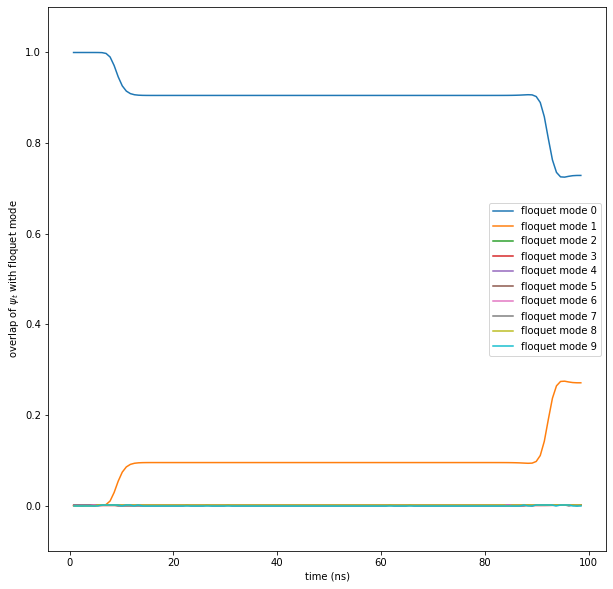

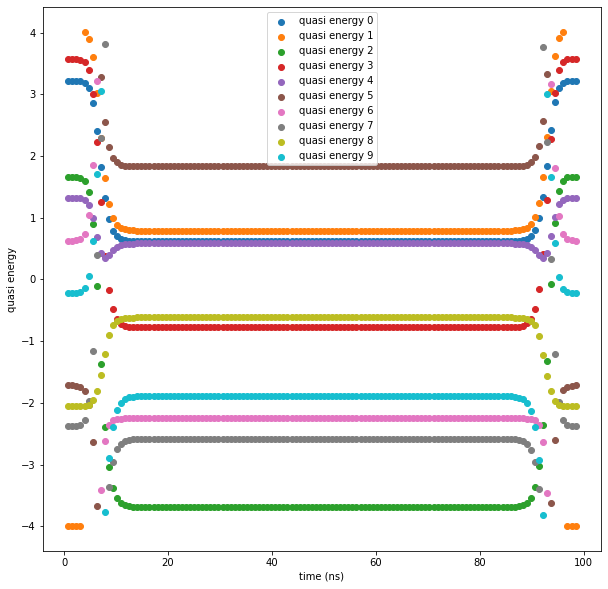

 ~ Looking at point 14 (100.000000 , 8.035000) ~ 


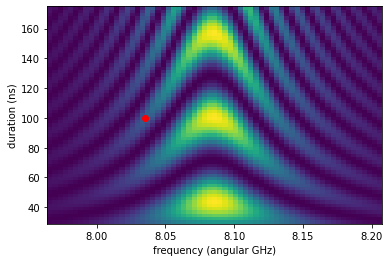

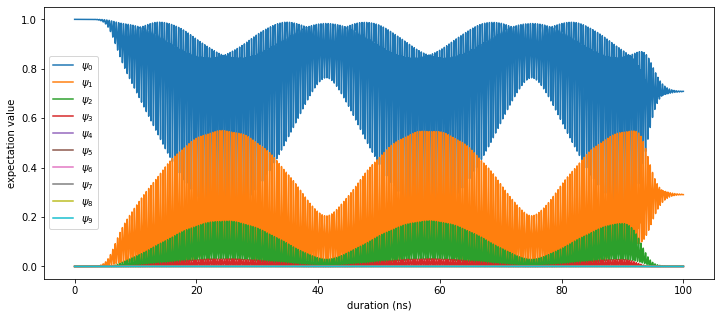

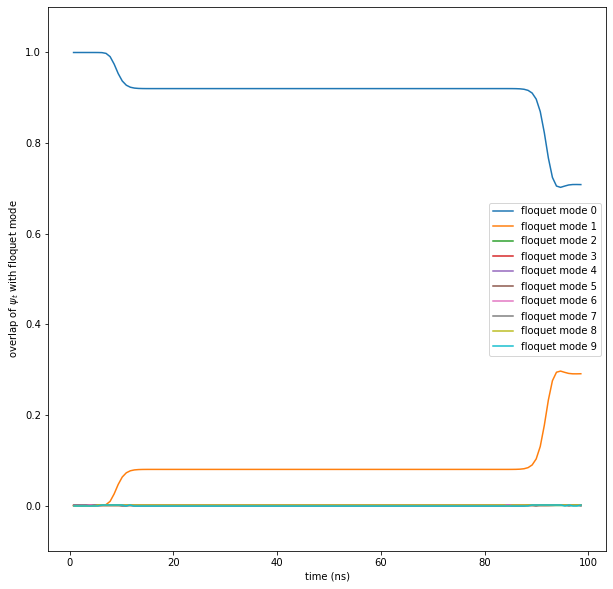

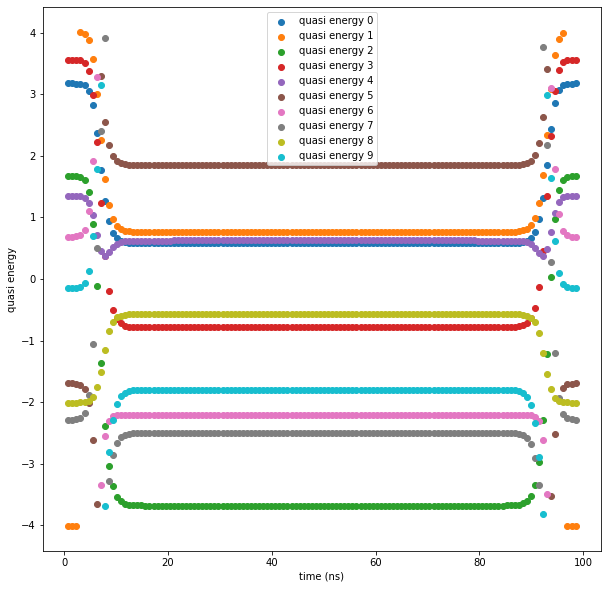

 ~ Looking at point 15 (100.000000 , 8.030000) ~ 


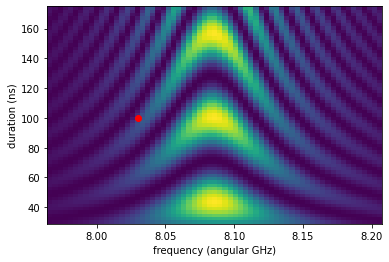

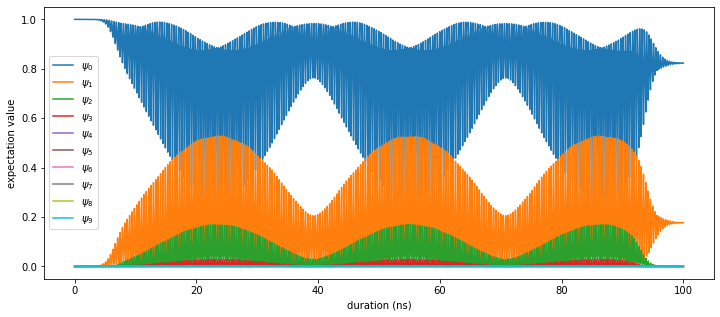

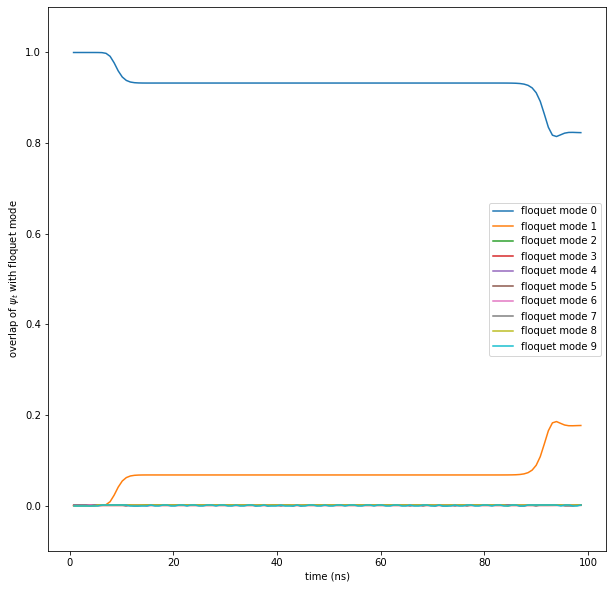

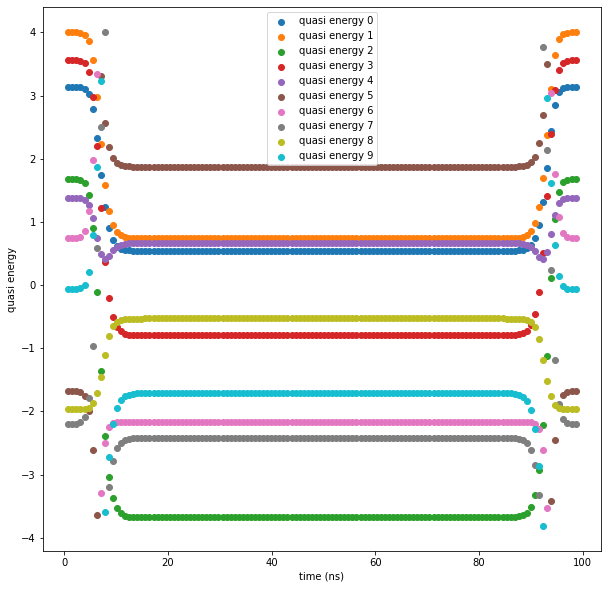

In [39]:
for i in range(len(points)):
    look_at_point(i)